In [1]:
""" import torch
from torch import tensor
from fft_conv import fft_conv

step = 5

a = tensor([1, 2, 3, 4], dtype=torch.float64)
b = tensor([1, 1, 0, 1], dtype=torch.float64)
w = tensor([step] * len(a), dtype=torch.float64)
w[0], w[-1] = step * 0.5, step * 0.5

(w * b) @ a """

' import torch\nfrom torch import tensor\nfrom fft_conv import fft_conv\n\nstep = 5\n\na = tensor([1, 2, 3, 4], dtype=torch.float64)\nb = tensor([1, 1, 0, 1], dtype=torch.float64)\nw = tensor([step] * len(a), dtype=torch.float64)\nw[0], w[-1] = step * 0.5, step * 0.5\n\n(w * b) @ a '

In [2]:
""" import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson
from fft_conv import fft_conv
import torch
import torch.nn.functional as f """

' import matplotlib.pyplot as plt\nimport numpy as np\nfrom scipy.integrate import simpson\nfrom fft_conv import fft_conv\nimport torch\nimport torch.nn.functional as f '

In [2]:
import numpy as np
import scipy
import torch
from torch import Tensor
import torch.nn.functional as f
from fft_conv import fft_conv
from scipy.stats import norm

def vector_norm(vector):
  return torch.norm(vector)**2


def l1_norm(start_point, end_point, array):
  nodes = np.linspace(start_point, end_point, len(array))
  return scipy.integrate.trapz(torch.abs(array).clone().detach().numpy(), nodes)


class Neumann:
    EPS = 1e-12

    def _calc_step(self):
        sqrt2pi = (2 * np.pi) ** 0.5
        logm = np.log(self.EPS * self.sm * sqrt2pi)
        logw = np.log(self.EPS * self.sw * sqrt2pi)

        if logm > 0 or logw > 0:
            t = 1
        else:
            xm = np.sqrt(-2 * (self.sm ** 2) * logm)
            xw = np.sqrt(-2 * (self.sw ** 2) * logw)
            t = max(xm, xw)

        return t / len(self.GT)
    
    def _calc_disribution(self, sigma):
        lspace = np.linspace(0, self.r, len(self.GT))
        return torch.tensor(scipy.stats.norm.pdf(lspace, scale=sigma))
    
    def __init__(self, GT, sm, sw, b, d, s, x0, r=15, n_iters=15):
        # save params
        self.n_iters = n_iters
        self.r = r
        
        self.b = b
        self.d = d
        self.s = s
        self.sm = sm
        self.sw = sw
        
        self.GT = torch.from_numpy(GT)
        
        # init m, w
        self.m = self._calc_disribution(sm) * self.b
        self.w = self._calc_disribution(sw) * self.s
        
        # step
        self.step = self._calc_step()
        
        #parameters to optimize
        self.x = torch.tensor(x0, requires_grad=True)
        
        self.lr = 0.1
        
        
    def _scalar_product(self, f: Tensor, g: Tensor) -> Tensor:
        w = torch.tensor([self.step] * len(self.GT), dtype=torch.double)
        w[0], w[-1] = [self.step * 0.5] * 2
        return 2 * f @ (w * g)
    
    def _get_convolutions(self, signal: Tensor, kernel: Tensor) -> Tensor:
        f = torch.reshape(signal, [1, 1, signal.size(-1)])
        g = torch.reshape(kernel, [1, 1, kernel.size(-1)])
        window_start = (f.size(-1)+1) // 2
        res = fft_conv(f, g, padding=f.size(-1) - 1)[..., window_start:window_start + f.size(-1)]
        res = torch.reshape(res, [f.size(-1)])
        return res * self.step / f.size(-1)
        
    def _convolve(self, C: Tensor) -> (Tensor, Tensor, Tensor):
        mC = self._get_convolutions(C, self.m)
        wC = self._get_convolutions(C, self.w)
        CwC = self._get_convolutions(C, self.w*C)
        return mC, wC, CwC

    def _neumann_iteration(self, N: Tensor, C: Tensor) -> (Tensor, Tensor):
        Y = self._scalar_product(C, self.w)
        N = (self.b - self.d) / (Y + self.s)
        mC, wC, CwC = self._convolve(C)
        C = (self.m / N - self.w + mC - N / (self.x[0] + self.x[2]) * (wC * (self.x[1] * (C + 1) + self.x[2]) + CwC * self.x[2])) / \
            (self.d + self.w + (self.x[0] * (self.b - self.d) + self.x[1] * self.s * N) / (self.x[0] + self.x[2]))
        return N, C
    def method(self) -> (Tensor, Tensor, Tensor, Tensor):
        C = self.w.clone().detach()
        N = torch.tensor([1.], requires_grad=False, dtype=torch.double)
        for i in range(self.n_iters):
            N, C = self._neumann_iteration(N, C)
        C += 1
        Q = vector_norm(C - self.GT)
        l1_norm_value = l1_norm(0., self.r, C - self.GT)
        return N, C, Q, self.x, l1_norm_value
    def proj_grad(self) -> Tensor:
        t = torch.ones(len(self.x), dtype=torch.double, requires_grad=False)
        norms = []
        for i in range(500):
            N, C, Q, x, l1_norm_value = self.method()
            Q.backward()
            with torch.no_grad():
                x -= self.lr * self.x.grad / torch.norm(self.x.grad)
                self.x.grad = None
            self.x = (x + (1 - x @ t) / 3 * t).clone().detach().requires_grad_(True)
            norms.append(Q.detach().numpy())
        N, C, Q, x, l1_norm_value = self.method()
        return self.x, norms, N, C, l1_norm_value
        

In [3]:
import pandas as pd

# Reading initial data from .csv-files...
count_of_data_frames = 1

sims = [pd.read_csv(f'./in_data/simulations_results/pcf/{i}.csv').fillna(method='bfill') for i in range(1, count_of_data_frames + 1)]
initial_parameters = [pd.read_csv(f'./in_data/simulations_results/initial_parameters/{i}.csv').fillna(method='bfill') for i in range(1, count_of_data_frames + 1)]
# This value is from R source code with simulations.
sm_temp = 0.96
# This value is from R source code with simulations.
sw_temp = 0.09
b = [initial_parameters[i]['b'] for i in range(0, count_of_data_frames)]
d = [initial_parameters[i]['d'] for i in range(0, count_of_data_frames)]
dds = np.array([initial_parameters[i]['dd'] for i in range(0, count_of_data_frames)])
# This is start value for running the optimization method and it may vary.
x0 = np.array([1.0, 1.0, -3.0])

In [4]:
solver_list = list()

for i in range(0, count_of_data_frames):
  solver_list.append(Neumann(np.array(sims[i]['pcf']), sm_temp, sw_temp, np.array(b[i])[0], np.array(d[i])[0], dds[i][0], x0, list(sims[i]['r'])[-1]))

In [5]:
n_list = list()
c_list = list()
q_list = list()
initial_x_list = list()
for solver in solver_list:
  N, C, Q, initial_x, norm = solver.method()
  n_list.append(N)
  c_list.append(C)
  q_list.append(norm)
  initial_x_list.append(initial_x)

In [7]:
#from torchviz import make_dot
#graph = [make_dot(Q, params={'x': solver.x}) for solver in solver_list]

In [8]:
# This is so long operation which draws all computational graph. Do it only if you really need.
#graph.view()

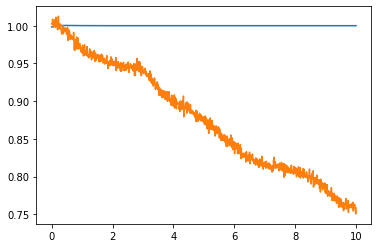

In [6]:
import matplotlib.pyplot as plt

index_of_data_set = 0
plt.plot(np.linspace(0., 10., len(c_list[index_of_data_set])), c_list[index_of_data_set].detach().numpy())
plt.plot(np.linspace(0., 10., len(sims[index_of_data_set]['pcf'])), sims[index_of_data_set]['pcf'])


In [8]:
import threading

max_count_of_active_threads = 4

def find_optimal_parameters_for_one_data_frame(index, solver_list, simulated_pcf, simulated_populations, results):
  """
  Функция, вычисляющая и записывающая в словарь оптимальные параметры замыкания и прочую сопутствующую информацию для одного набора данных.
  @param index: int -- индекс набора данных, для которого требуется провести расчёт.
  @param solver_list: list(Neumann) -- список всех объектов для вычисления.
  @param simulated_pcf: list(pandas.DataFrame) -- список всех наборов симулированных функций парной корреляции.
  @param simulated_populations: list(float) -- список всех симулированных значений количеств особей.
  @param results: dict -- словарь, куда требуется записать результаты расчётов.
  """
  x, norms, optimal_N, optimal_C, l1_norm_value = solver_list[i].proj_grad()
  results.update(
    {
      index: {
        'alpha': x[0].item(),
        'beta': x[1].item(),
        'gamma': x[2].item(),
        'relative_pcf_error': l1_norm_value / l1_norm(0., list(sims[i]['r'])[-1], torch.tensor(simulated_pcf[i]['pcf'])),
        'relative_population_error': abs((optimal_N.item() - simulated_populations[i]) / simulated_populations[i]),
        'optimal_C': optimal_C,
        'pcf_norms_in_time': norms,
      },
    },
  )

simulated_populations = [
  pd.read_csv(f'./in_data/simulations_results/population/{i}.csv')['pop'][-1:].item()
  for i in range(1, count_of_data_frames + 1)
]

results_dict = {}
current_count_of_active_threads = 0
first_active_thread_index = 0
threads_list = []
for i in range(0, count_of_data_frames):
  while current_count_of_active_threads > max_count_of_active_threads:
    threads_list[first_active_thread_index].join()
    current_count_of_active_threads -= 1
    first_active_thread_index += 1
  
  threads_list.append(threading.Thread(target=find_optimal_parameters_for_one_data_frame, args=(i, solver_list, sims, simulated_populations, results_dict)))
  threads_list[-1].start()
  current_count_of_active_threads += 1
for i in range(first_active_thread_index, count_of_data_frames):
  threads_list[i].join()

alphas = list()
betas = list()
gammas = list()
norms_list = list()
N_error_list = list()
optimal_C_list = list()

for i in range(0, count_of_data_frames):
  result = results_dict[i]
  alphas.append(result['alpha'])
  betas.append(result['beta'])
  gammas.append(result['gamma'])
  norms_list.append(result['relative_pcf_error'])
  N_error_list.append(result['relative_population_error'])
  optimal_C_list.append(result['optimal_C'])

data_frame = pd.DataFrame(
  {
    'id': list(range(1,len(alphas) + 1)),
    'in_b': [sample['b'].item() for sample in initial_parameters],
    'in_d': [sample['d'].item() for sample in initial_parameters],
    'in_dd': [sample['dd'].item() for sample in initial_parameters],
    'alpha': alphas,
    'beta': betas,
    'gamma': gammas,
    'pop_error': N_error_list,
    'pcf_error': norms_list,
  },
)
data_frame.to_csv('./out_data/result.csv', index=False)

Q:20.570641128749102, current x:tensor([ 2.3899, -2.1761,  0.7862], dtype=torch.float64, requires_grad=True)
2.570069773075934
-2.3928906973240927
0.8228209242481587
Q:23.39748361979417, current x:tensor([ 1.6939,  1.6531, -2.3469], dtype=torch.float64, requires_grad=True)
2.66612330388528
-1.9336792176715574
0.2675559137862777
Q:30.878741653899997, current x:tensor([ 1.6939,  1.6531, -2.3469], dtype=torch.float64, requires_grad=True)
2.7469797385290518
-1.4504981846928526
-0.2964815538361992
Q:46.49326724974703, current x:tensor([ 1.6939,  1.6531, -2.3469], dtype=torch.float64, requires_grad=True)
2.8221602324794386
-1.556746613092324
-0.26541361938711433
Q:67.7038926555363, current x:tensor([ 1.6938,  1.6531, -2.3469], dtype=torch.float64, requires_grad=True)
2.529725836768402
-1.8132429469832771
0.2835171102148748
Q:21.671204720879977, current x:tensor([ 1.6939,  1.6531, -2.3469], dtype=torch.float64, requires_grad=True)
2.16743458821911
-2.2543304333868366
1.0868958451677264
Q:23.7

In [9]:
for key, value in results_dict.items():
  value['pcf_norms_in_time'] = np.array(value['pcf_norms_in_time'])
  value['pcf_norms_in_time'].shape

In [10]:
%config InlineBackend.figure_format = 'retina'

In [11]:
def myplot(x, y, xlab, ylab, xscale="linear", yscale="log"):
    plt.figure(figsize=(10, 8))
    plt.xscale(xscale)
    plt.yscale(yscale)
    for key in y:
        plt.semilogy(x[key], y[key], label=key)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(loc="best", fontsize=24)
    plt.xlabel(xlab, fontsize=24)
    plt.ylabel(ylab, fontsize=24)

In [12]:
index_of_data_set = 0
norms = results_dict[index_of_data_set]['pcf_norms_in_time']
relative_pcf_error = results_dict[index_of_data_set]['relative_pcf_error']

%matplotlib inline
plt.rc("text", usetex=True)
myplot({"PG": range(1, len(norms) + 1)},
       {"PG": norms}, "Number of iterations",
       r"Objective function $Q = \|C - C_{sim}\|^2_2$")
print(f'Индекс набора данных: {index_of_data_set}')
print(f"Относительная погрешность, %: {relative_pcf_error * 100}")

TypeError: len() of unsized object

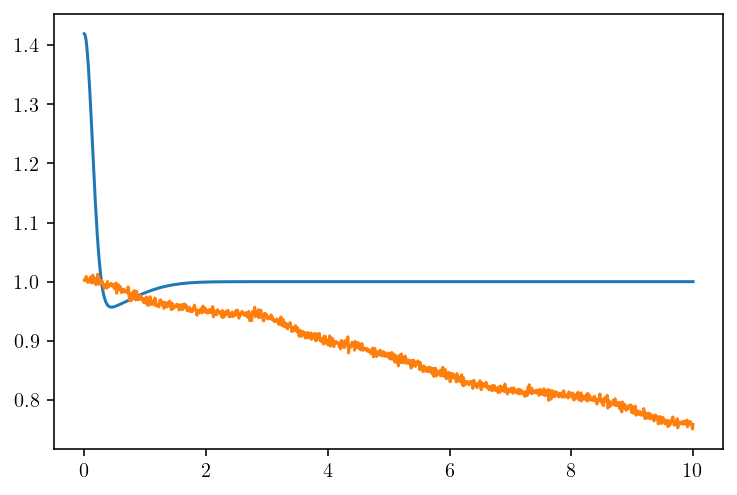

In [21]:
index_of_data_set = 0
optimal_C = optimal_C_list[index_of_data_set]
plt.plot(np.linspace(0., 10., len(sims[index_of_data_set]['pcf'])), sims[index_of_data_set]['pcf'])
plt.plot(np.linspace(0., 10., len(optimal_C)), optimal_C.detach().numpy())
